In [1]:
import os
import allel
from numba import njit
import malariagen_data

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns
import plotly.express as px

In [2]:
from zmq import NULL
@njit()
def ibdscans(geno, pos):
    """
    Scans across two genotype vectors, checking and recording SNPs which are either
    are homozygous but different (IBD1 breakpoint) or have any alleles different (IBD2 breakpoint)
    """

    geno1 = geno[:, 0]
    geno2 = geno[:, 1]

    ibd1_breakpoints = []
    ibd2_breakpoints = []
    # Scan right along genome, as long as two inds are not both homozygous but different
    for pos_idx in range(pos.shape[0]):

        gn1 = geno1[pos_idx]
        gn2 = geno2[pos_idx]

        # if both alleles are not identical, record the position
        if not (gn1 == gn2).all() and (-1 not in gn1 and -1 not in gn2):
            ibd2_breakpoints.append(pos_idx)
            # if both alleles are not identical and not missing, and both are homozygous, record the position
            if (gn1[0] == gn1[1]) and (gn2[0] == gn2[1]) and ((gn1 != gn2).all()) and (-1 not in gn1 and -1 not in gn2):
                ibd1_breakpoints.append(pos_idx)

    return np.array(ibd1_breakpoints), np.array(ibd2_breakpoints)

def detect_ibd_segments(contig, test_sets=None, test_size=None, test_query=None, ref_sets=None, ref_size=None, ref_query=None, prefix="", site_mask='gamb_colu', save_path=None, ibd1_size = 100_000, ibd2_size = 10_000, use_n_snps = False):
    """
    Loads genotype data, and runs IBD scan on each pair of individuals, writing IBD segments to
    a .tsv file.
    """
    from itertools import product

    geno, pos, (sample_ids_test, sample_ids_ref) = load_genotypes(
        contig=contig,
        test_sets=test_sets,
        test_size=test_size,
        test_query=test_query,
        ref_sets=ref_sets,
        ref_size=ref_size,
        ref_query=ref_query,
        site_mask=site_mask
    )

    for x,y in tqdm(product(range(test_size), range(ref_size))):
        sample1 = sample_ids_test[x]
        sample2 = sample_ids_ref[y]
        ibd1, ibd2 = ibdscans(geno.take([x,test_size+y], axis=1), pos)

        if save_path:
          ibd1_path = save_path + f"/{prefix}.{contig}.ibd1.tsv"
          ibd2_path = save_path + f"/{prefix}.{contig}.ibd2.tsv"
        else:
          ibd1_path = f"{prefix}.{contig}.ibd1.tsv"
          ibd2_path = f"{prefix}.{contig}.ibd2.tsv"

        ## IBD 1
        pos_ibd1 = pos[ibd1]
        n_snps_ibd1 = np.ediff1d(ibd1)
        sizes_ibd1 = np.ediff1d(pos_ibd1)
        ibd1_segments_df = pd.DataFrame({'size':sizes_ibd1,
                                      'n_snps':n_snps_ibd1,
                                      'start':pos_ibd1[:-1],
                                      'end':pos_ibd1[1:]})
        if use_n_snps:
          ibd1_segments_df = ibd1_segments_df.query("n_snps > " + str(ibd1_size))
        else:
          ibd1_segments_df = ibd1_segments_df.query("size > " + str(ibd1_size))
        ibd1_segments_df.assign(
            contig=contig,
            index1=x,
            index2=y,
            sample1=sample1,
            sample2=sample2).to_csv(ibd1_path, sep="\t", mode='a', index = False, header=not os.path.exists(ibd1_path))

        ## IBD 2
        pos_ibd2 = pos[ibd2]
        n_snps_ibd2 = np.ediff1d(ibd2)
        sizes_ibd2 = np.ediff1d(pos_ibd2)
        ibd2_segments_df = pd.DataFrame({'size':sizes_ibd2,
                                      'n_snps':n_snps_ibd2,
                                      'start':pos_ibd2[:-1],
                                      'end':pos_ibd2[1:]})
        if use_n_snps:
          ibd2_segments_df = ibd2_segments_df.query("n_snps > " + str(ibd1_size))
        else:
          ibd2_segments_df = ibd2_segments_df.query("size > " + str(ibd1_size))
        ibd2_segments_df.assign(
            contig=contig,
            index1=x,
            index2=y,
            sample1=sample1,
            sample2=sample2).to_csv(ibd2_path, sep="\t", mode="a", index = False, header=not os.path.exists(ibd2_path))
    return sample_ids_test, sample_ids_ref


def load_genotypes(contig, test_sets, test_size, test_query, ref_sets, ref_size, ref_query, site_mask):
    """
    Loads SNP calls and throws out invariant, singleton and doubleton sites, which
    massively speeds up IBD scanning algorithm.
    """

    import xarray as xr

    print("Loading genotypes")
    ds_snps_test = ag3.snp_calls(region=contig, sample_sets=test_sets, cohort_size=test_size, sample_query=test_query, site_mask=site_mask)
    ds_snps_ref = ag3.snp_calls(region=contig, sample_sets=ref_sets, cohort_size=ref_size, sample_query=ref_query, site_mask=site_mask)
    ds_snps = xr.concat([ds_snps_test, ds_snps_ref], dim='samples')
    geno = allel.GenotypeDaskArray(ds_snps['call_genotype'].values)
    sample_ids = (ds_snps_test['sample_id'].values, ds_snps_ref['sample_id'].values)
    print("computing allele counts")
    ac = geno.count_alleles().compute()

    seg = ac.is_segregating()
    dbl = ac.is_doubleton(allele=1)
    dbl2 = ac.is_doubleton(allele=2)
    dbl3 = ac.is_doubleton(allele=3)
    dbl = np.logical_or(dbl, np.logical_or(dbl2, dbl3))
    sngl = ac.is_singleton(allele=1)
    sngl2 = ac.is_singleton(allele=2)
    sngl3 = ac.is_singleton(allele=3)

    mask = np.logical_and(seg, ~np.logical_or(dbl, np.logical_or(sngl, np.logical_or(sngl2, sngl3))))
    print(f"retaining {mask.sum()} variants and removing {(~mask).sum()}")

    geno = geno[mask].compute().values
    pos = ds_snps['variant_position'].values[mask]

    return geno, pos, sample_ids

In [3]:
def summarise_ibd_data(prefix='coluzzii', ibd1_min_size=1000, ibd2_min_size=100, save_path=None, use_snps = False):
    from dask import dataframe as dd
    import malariagen_data

    #ag3 = malariagen_data.Ag3("gs://vo_agam_release/", pre=True)
    genome_size = np.sum([ag3.genome_sequence(contig).shape[0] for contig in ag3.virtual_contigs + ('X',)])

    ibd1_list = []
    ibd2_list = []
    for i, contig in enumerate(ag3.virtual_contigs + ('X',)):
        if save_path:
          ibd1_path = save_path + f"/{prefix}.{contig}.ibd1.tsv"
          ibd2_path = save_path + f"/{prefix}.{contig}.ibd2.tsv"
        else:
          ibd1_path = f"{prefix}.{contig}.ibd1.tsv"
          ibd2_path = f"{prefix}.{contig}.ibd2.tsv"
        print(f"reading ibd1 {contig}...")
        ibd1_df_all = dd.read_csv(ibd1_path, sep="\t")
        ibd2_df_all = dd.read_csv(ibd2_path, sep="\t")
        if use_snps:
            if len(ibd1_df_all) !=0:
                ibd1_df = ibd1_df_all.query(f"n_snps > {ibd1_min_size}")
            else:
                print("Empty dataframe: ibd1")
                ibd1_df = ibd1_df_all
        else:
            if len(ibd1_df_all) !=0:
                ibd1_df = ibd1_df_all.query(f"size > {ibd1_min_size}")
            else:
                print("Empty dataframe: ibd1")
                ibd1_df = ibd1_df_all
        print(f"reading ibd2 {contig}...")
        if use_snps:
            if len(ibd2_df_all) !=0:
                ibd2_df = ibd2_df_all.query(f"n_snps > {ibd2_min_size}")
            else:
                print("Empty dataframe: ibd2")
                ibd2_df = ibd2_df_all
        else:
            if len(ibd2_df_all) !=0:
                ibd2_df = ibd2_df_all.query(f"size > {ibd2_min_size}")
            else:
                print("Empty dataframe: ibd2")
                ibd2_df = ibd2_df_all

        ibd1_data = ibd1_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd2_data = ibd2_df.groupby(['index1', 'index2']).agg({'size':'sum', 'n_snps':'sum'}).assign(contig=contig)
        ibd1_list.append(ibd1_data)
        ibd2_list.append(ibd2_data)

    print("computing...")
    ibd1_stats = dd.concat(ibd1_list).compute()
    ibd2_stats= dd.concat(ibd2_list).compute()
    if save_path:
      ibd1_stats.to_csv(save_path + "/ibd1.per_contig.tsv", sep="\t")
      ibd2_stats.to_csv(save_path + "/ibd2.per_contig.tsv", sep="\t")
    else:
      ibd1_stats.to_csv("ibd1.per_contig.tsv", sep="\t")
      ibd2_stats.to_csv("ibd2.per_contig.tsv", sep="\t")

    ibd1_stats = ibd1_stats.reset_index().rename(columns={'size':'ibd1_size'}).groupby(['index1', 'index2']).agg({'ibd1_size':'sum'}).assign(ibd1_fraction=lambda x: x['ibd1_size']/genome_size)
    ibd2_stats = ibd2_stats.reset_index().rename(columns={'size':'ibd2_size'}).groupby(['index1', 'index2']).agg({'ibd2_size':'sum'}).assign(ibd2_fraction=lambda x: x['ibd2_size']/genome_size)
    ibd_stats = pd.concat([ibd1_stats, ibd2_stats], axis=1)

    if save_path:
      ibd_stats.to_csv(save_path + f"/{prefix}.ibd.summary.tsv", sep="\t")
    else:
      ibd_stats.to_csv(f"{prefix}.ibd.summary.tsv", sep="\t")
    return ibd_stats, ibd1_stats, ibd2_stats

In [4]:
def compute_ibd(test_sets, test_size, test_query, ref_sets, ref_size, ref_query, site_mask, prefix, save_path, ibd1_size, ibd2_size):
  for contig in ag3.virtual_contigs + ('X',):
    print(contig)
    sample_names_test, sample_names_ref = detect_ibd_segments(
        contig=contig,
        test_sets=test_sets,
        test_size=test_size,
        test_query=test_query,
        ref_sets=ref_sets,
        ref_size=ref_size,
        ref_query=ref_query,
        site_mask=site_mask,
        prefix=prefix,
        save_path=save_path,
        ibd1_size = ibd1_size,
        ibd2_size = ibd2_size
    )
  ibd_stats, ibd1_stats, ibd2_stats = summarise_ibd_data(prefix=prefix, ibd1_min_size= ibd1_size, ibd2_min_size= ibd2_size, save_path = save_path)
  ibd1_ar = np.zeros((test_size,ref_size,))
  ibd2_ar = np.zeros((test_size,ref_size,))
  for index, row in ibd_stats.iterrows():
    if not np.isnan(row['ibd1_fraction']):
      ibd1_ar[index[0],index[1]] = row['ibd1_fraction']
    if not np.isnan(row['ibd2_fraction']):
      ibd2_ar[index[0],index[1]] = row['ibd2_fraction']
  ibd1_df = pd.DataFrame(data = ibd1_ar,
                index = sample_names_test,
                columns = sample_names_ref
                )
  ibd2_df = pd.DataFrame(data = ibd2_ar,
                index = sample_names_test,
                columns = sample_names_ref
                )
  return ibd1_df, ibd2_df, sample_names_test, sample_names_ref

In [5]:
ag3 = malariagen_data.Ag3(pre=True)

In [13]:
ao_ao_ci_ibd1_df, ao_ao_ci_ibd2_df, _, _ = compute_ibd(
        test_sets='AG1000G-AO',
        test_size=5,
        test_query=None,
        ref_sets=['AG1000G-AO','AG1000G-CI'],
        ref_size=10,
        ref_query=None,
        site_mask='gamb_colu',
        prefix="ident",
        save_path="AO_AO_CI_50000_5000_id",
        ibd1_size = 50000,
        ibd2_size = 5000
    )

2RL
Loading genotypes
computing allele counts
retaining 2012401 variants and removing 78432489


0it [00:00, ?it/s]

3RL
Loading genotypes
computing allele counts
retaining 1712827 variants and removing 64194431


0it [00:00, ?it/s]

X
Loading genotypes
computing allele counts
retaining 235630 variants and removing 16127179


0it [00:00, ?it/s]

reading ibd1 2RL...
reading ibd2 2RL...
reading ibd1 3RL...
reading ibd2 3RL...
reading ibd1 X...
reading ibd2 X...
computing...


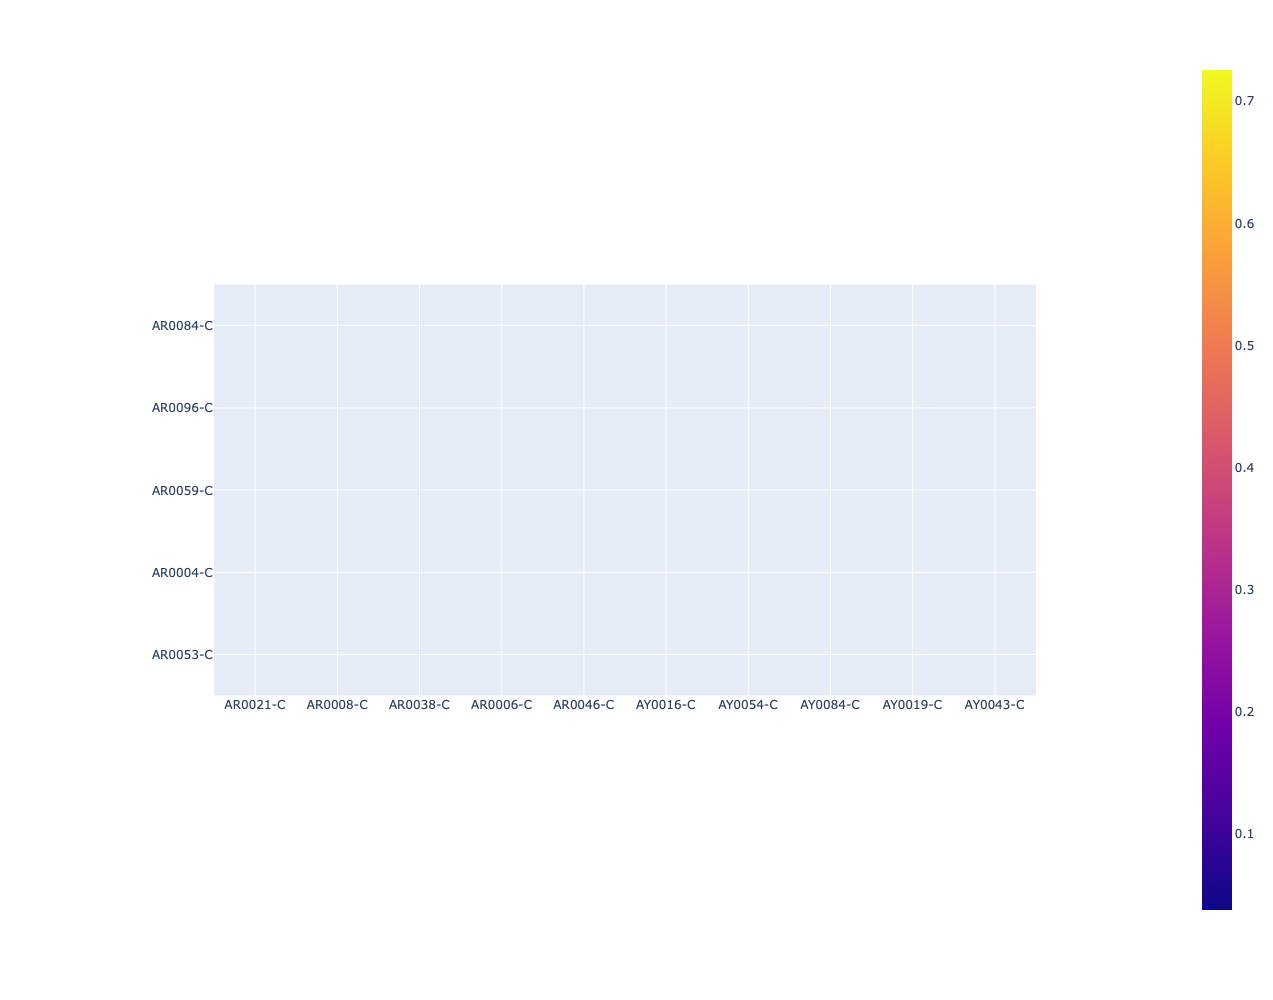

In [14]:
px.imshow(ao_ao_ci_ibd1_df, width = 1000, height = 1000)

In [15]:
ci_ao_ci_ibd1_df,ci_ao_ci_ibd2_df, _, _ = compute_ibd(
        test_sets='AG1000G-CI',
        test_size=5,
        test_query=None,
        ref_sets=['AG1000G-AO','AG1000G-CI'],
        ref_size=10,
        ref_query=None,
        site_mask='gamb_colu',
        prefix="ident",
        save_path="CI_AO_CI_50000_5000_id",
        ibd1_size = 50000,
        ibd2_size = 5000
    )

2RL
Loading genotypes
computing allele counts
retaining 2145295 variants and removing 78299595


0it [00:00, ?it/s]

3RL
Loading genotypes
computing allele counts
retaining 1769774 variants and removing 64137484


0it [00:00, ?it/s]

X
Loading genotypes
computing allele counts
retaining 248136 variants and removing 16114673


0it [00:00, ?it/s]

reading ibd1 2RL...
reading ibd2 2RL...
reading ibd1 3RL...
reading ibd2 3RL...
reading ibd1 X...
reading ibd2 X...
computing...


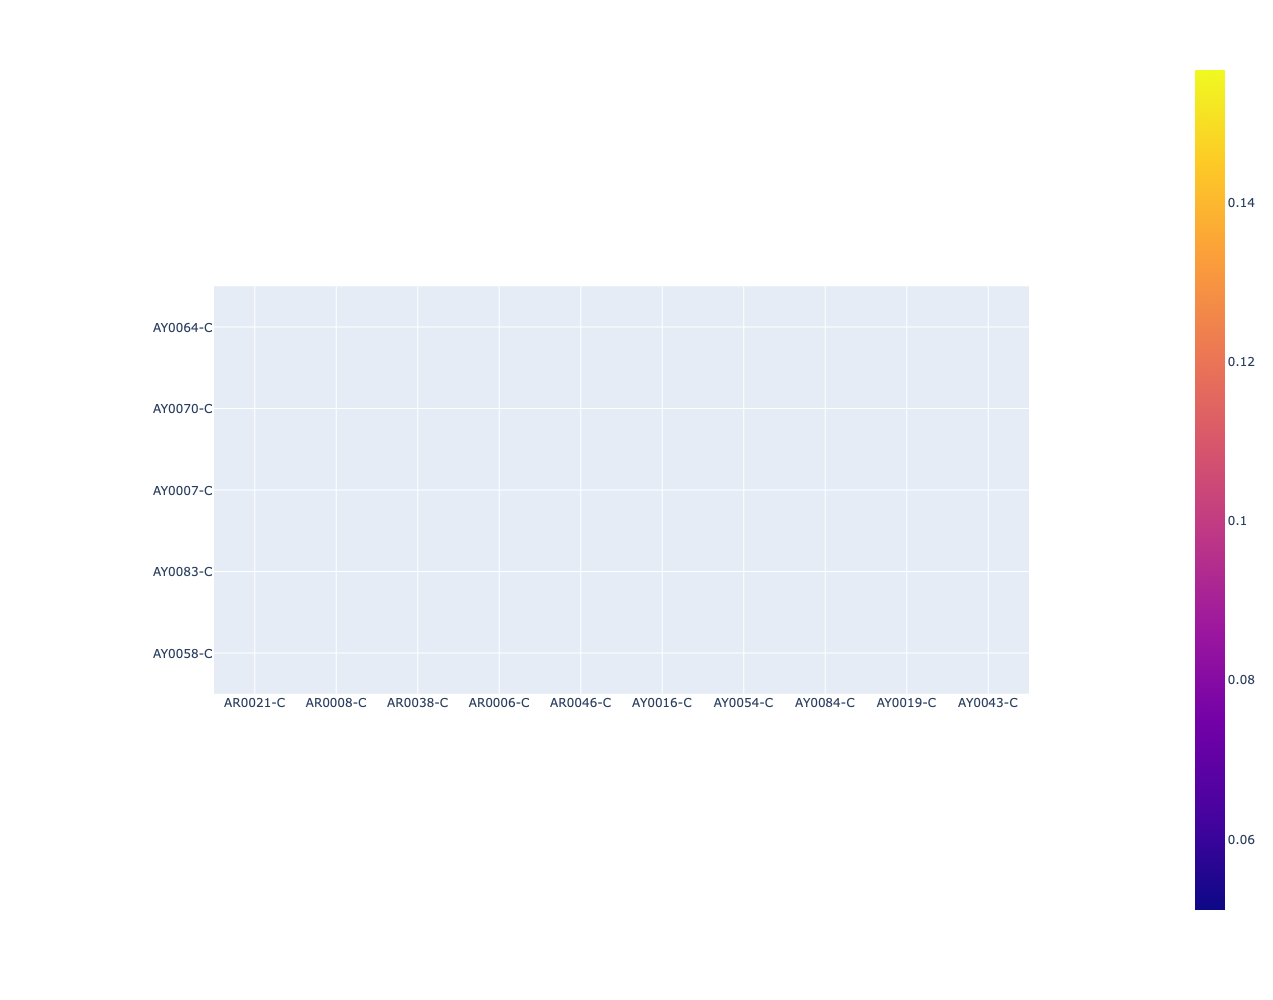

In [17]:
px.imshow(ci_ao_ci_ibd1_df, width = 1000, height = 1000)